In [2]:
#Load the datasets
import pickle
allCommentary = pickle.load(open('allCommentary', 'rb'))
allNews = pickle.load(open('allNews', 'rb'))

In [5]:
############################### MOVING ONTO UNSUPERVISED SENTIMENT ANALYSIS ###############################
#The following code comes from the Kaggle tutorial here: https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial/data
#With some modification
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency
import spacy
#Needed to run this command on terminal even after installing spacy: python -m spacy download en
nlp = spacy.load('en', disable=['ner', 'parser'])

In [6]:
def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [7]:
#Make new column in dataframe where we will process specifically for word2vec
allCommentary['w2vProcessed'] = allCommentary["Processed"]

#Remove non alphabetic characters
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in allCommentary['w2vProcessed'])

In [8]:
#Perform cleaning, the time to clean was about 5 minutes
t = time()
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 3.95 mins


In [9]:
#df_clean has the cleaned data now, there are 3380 rows
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(3380, 1)

In [10]:
from gensim.models.phrases import Phrases, Phraser
sent = [row.split() for row in df_clean['clean']]
phrases = Phrases(sent, min_count=30, progress_per=10000)

In [11]:
#Accounts for bigrams
#(if there are two wordss that appear together a lot, they might be one phrase to be considered together
bigram = Phraser(phrases)
sentences = bigram[sent]

In [12]:
#check the most frequent words 
#after lemmatization (changing tenses), removing stopwords
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
#Checking the number of unique words
len(word_freq)


44007

In [13]:
#Printing out the top 10 most frequent words:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['law',
 'court',
 'state',
 'case',
 'right',
 'government',
 'act',
 'legal',
 'issue',
 'decision']

In [14]:
#Now, we need to train the model
#Using the Gensim implementation of word2vec
import multiprocessing
from gensim.models import Word2Vec
# Count the number of cores in a computer to parallelize
cores = multiprocessing.cpu_count() 

In [15]:
#Specific parameters described here: https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

w2v_model = Word2Vec(min_count=10, 
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [16]:
#Building vocab table
t = time()
w2v_model.build_vocab(sentences, progress_per=10000)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.1 mins


In [17]:
#Training the model

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))


Time to train the model: 3.26 mins


In [19]:
import pickle
filename = 'w2v-commentary-model'
pickle.dump(w2v_model, open(filename, 'wb'))

In [20]:
#Can load trained model to reduce time
import pickle
filename = 'w2v-commentary-model'
loaded_model = pickle.load(open(filename, 'rb'))

In [22]:
#Find the word most similar to US
loaded_model.wv.most_similar(positive=["united_states"])

[('u_s', 0.5360903739929199),
 ('country', 0.36530762910842896),
 ('henceforth', 0.35295504331588745),
 ('naturalize', 0.3429434895515442),
 ('overseas', 0.33185648918151855),
 ('chastise', 0.32999324798583984),
 ('ally', 0.32874542474746704),
 ('commander_chief', 0.3037393093109131),
 ('american_citizen', 0.3011128902435303),
 ('nation', 0.2975391745567322)]

In [23]:
word_vectors = loaded_model.wv

The code above this was simply to make the word vector embeddings. Each word is now represented as 300 dimensional vector, trained on the word2vec library.In the following code, we will cluster the word vector representations.
Our hope is that the main clusters that will form will be positive and negative. In the past, when there were only two clusters, one of the clusters was just author names, and the other cluster was a bunch of random other words.
 Now, we have filtered out many of the author names but to avoid this problem, I have found that using 3 clusters tends to work because one of the clusters is centered around the authors/other miscellaneous JURIST-related words.

In [24]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=3, max_iter=1000, random_state=True, n_init=50).fit(X=word_vectors.vectors)
first_cluster_center = model.cluster_centers_[0]
second_cluster_center = model.cluster_centers_[1]
third_cluster_center = model.cluster_centers_[1]

In [80]:
#Cluster indexed number 2 is mostly the author names that remain
word_vectors.similar_by_vector(model.cluster_centers_[2], topn=1000, restrict_vocab=None)

[('columnists', 0.8491202592849731),
 ('maureen', 0.7994683980941772),
 ('m_crane', 0.7822014093399048),
 ('dwight', 0.7813552021980286),
 ('schaeffer', 0.7804142832756042),
 ('mckee', 0.773609459400177),
 ('linge', 0.7732653617858887),
 ('phil', 0.7655422687530518),
 ('emerita', 0.7632888555526733),
 ('brad', 0.7624174356460571),
 ('vikram', 0.7612065076828003),
 ('wendell', 0.7539517879486084),
 ('stetson', 0.751528263092041),
 ('associates', 0.7514290809631348),
 ('columnist_david', 0.7487485408782959),
 ('rist', 0.7472808361053467),
 ('herbert', 0.745795488357544),
 ('ilan', 0.7435328960418701),
 ('duffy', 0.7395432591438293),
 ('zeller', 0.7388975620269775),
 ('ala', 0.7370482683181763),
 ('jon', 0.735040545463562),
 ('laude', 0.7342791557312012),
 ('kamatali', 0.7330186367034912),
 ('teresa', 0.7328463792800903),
 ('bernard', 0.7308796644210815),
 ('marcus', 0.7277274131774902),
 ('sj', 0.7270316481590271),
 ('cruz', 0.7265952229499817),
 ('hartmann', 0.7232362031936646),
 ('lynn

In [36]:
import numpy as np

words = pd.DataFrame(list(word_vectors.vocab.keys()))
words.columns = ['words']


In [76]:
words['vectors'] = words['words'].apply(lambda x: word_vectors.wv[f'{x}'])
words['cluster'] = words['vectors'].apply(lambda x: model.predict(x.reshape(1,-1))[0])
words = words[words['cluster'] != 2]
words['cluster_value'] = [1 if i==0 else -1 for i in words.cluster]
words['closeness_score'] = words.apply(lambda x: 1/(model.transform([x.vectors]).min()), axis=1)
words['sentiment_coeff'] = words.closeness_score * words.cluster_value

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


In [79]:
#We have removed the words in the 2nd cluster because they were mostly author names
#Now, let's see the resulting words with the most positive sentiment score
words.sort_values(by=['sentiment_coeff'], ascending=False).head(10)

,words,vectors,cluster,cluster_value,closeness_score,sentiment_coeff
8111,rebuttal,"[0.03972912, 0.0019807138, 0.06442195, -0.1893...",0,1,0.397912,0.397912
6824,uncontested,"[-0.15886779, -0.0058217235, 0.08983982, 0.056...",0,1,0.366533,0.366533
7174,unsuitable,"[0.28138506, 0.026874283, 0.1621727, 0.0235830...",0,1,0.362438,0.362438
9887,retrospective,"[0.021082195, -0.19421789, -0.14880645, 0.1805...",0,1,0.362354,0.362354
6300,heretofore,"[-0.07904373, 0.09151741, 0.22967422, 0.046733...",0,1,0.360821,0.360821
10206,circumscribe,"[-0.05668941, -0.31045806, 0.07931762, 0.25077...",0,1,0.348591,0.348591
9493,enforcer,"[0.14830527, -0.20780817, 0.056666296, 0.03602...",0,1,0.348388,0.348388
10860,tr,"[0.10477918, -0.14581342, -0.061572768, -0.031...",0,1,0.346897,0.346897
9799,nominally,"[-0.23945056, -0.24579923, 0.19649431, 0.18817...",0,1,0.346439,0.346439
10038,cognizance,"[-0.05019778, -0.03138433, 0.15614535, 0.21622...",0,1,0.346231,0.346231


In [78]:
#and with the most negative scores
words.sort_values(by=['sentiment_coeff'], ascending=True).head(50)

,words,vectors,cluster,cluster_value,closeness_score,sentiment_coeff
6075,idle,"[0.07365447, 0.07769126, -0.0021598972, 0.1411...",1,-1,0.403466,-0.403466
9365,hapless,"[-0.078748226, 0.027065577, 0.028747553, 0.135...",1,-1,0.393690,-0.393690
7326,folly,"[-0.14286155, -0.08583535, -0.12353798, -0.010...",1,-1,0.389583,-0.389583
7260,ruthless,"[0.020773169, -0.04673326, 0.032189436, 0.2442...",1,-1,0.387993,-0.387993
7236,luckily,"[-0.18562685, -0.12853037, 0.16233552, -0.1149...",1,-1,0.387479,-0.387479
5712,beware,"[-0.43674937, 0.0065363655, 0.021720607, 0.271...",1,-1,0.380248,-0.380248
8470,dearly,"[-0.22893284, 0.14269282, 0.07971611, 0.222528...",1,-1,0.370472,-0.370472
10560,localize,"[0.2078257, 0.19274989, -0.16547704, 0.4256911...",1,-1,0.370425,-0.370425
7826,baffle,"[-0.28074494, 0.030261297, -0.20120567, 0.0822...",1,-1,0.366489,-0.366489
8987,sporadic,"[0.08653127, 0.0005144404, 0.028223107, 0.1621...",1,-1,0.366301,-0.366301


It seems to be a somewhat more accurate representation of sentiment! 

In [131]:
#Making a function to add sentiment scores of individual words to generate sentiment for an overall text
def getSentimentScore(dictionary, text):
    text = re.sub('[^a-z\ \']+', " ", text.lower())
    text = list(text.split())
    sentiment = 0
    for word in text: 
        if(str(word) in dictionary.keys()):
            sentiment += dictionary[str(word)]
        
    return sentiment   



In [132]:
#Making a dictionary of sentiment socres to apply
sentDict = dict(zip(words.words, words.sentiment_coeff))
allCommentary['ClusteredSentimentScores'] = allCommentary.apply(lambda row: getSentimentScore(sentDict,row['Processed']), axis = 1)


In [137]:
#Seems to be somewhat accurate in terms of the most negative articles
allCommentary.sort_values('ClusteredSentimentScores', ascending = True)

,Title,PubDate,Tags,Author,Affiliation,Link,Text,Processed,w2vProcessed,ClusteredSentimentScores
3309,Implicit Threats of Violence: The American Pre...,"Mon, 27 Apr 2020 00:07:24 +0000","Donald Trump, Trump rallies, violence",Louis Rene Beres,,https://www.jurist.org/commentary/2020/04/loui...,"<blockquote>""Whoever can conquer the street wi...","""Whoever can conquer the street will one day c...","""Whoever can conquer the street will one day c...",-28.947341
1316,China's oppression of Uyghurs remains largely ...,"Tue, 21 Jul 2009 03:31:00 +0000","china, Kazakhstan, Russia, Terrorism, Tibet, U...",,,https://www.jurist.org/commentary/2009/07/chin...,<p><strong>Mehmet Tohti</strong> [Former Vice ...,Horrible video footage posted on the internet ...,Horrible video footage posted on the internet ...,-27.867072
1060,The Credit Crisis: Taking the Long View,"Thu, 09 Oct 2008 12:01:00 +0000",United States,,,https://www.jurist.org/commentary/2008/10/cred...,"<p>JURIST Contributing Editor <a href=""http://...",Harking back to the days of Ozzie and Harriet ...,Harking back to the days of Ozzie and Harriet ...,-26.342385
1832,Unintended Consequences: Gaddafi&apos;s Death ...,"Sat, 29 Oct 2011 19:00:00 +0000","Arab Spring, Libya, Libya Conflict, Muammar Ga...",,,https://www.jurist.org/commentary/2011/10/jord...,"<p>JURIST Guest Columnist Jordan Toone, <a hre...","JURIST Guest Columnist Jordan Toone, Universit...","JURIST Guest Columnist Jordan Toone, Universit...",-26.031153
2367,Syria: The Purgatory of the &apos;Arab Spring&...,"Fri, 13 Sep 2013 13:00:00 +0000",Syria,,,https://www.jurist.org/commentary/2013/09/enve...,"<p>JURIST Guest Columnist <a href=""http://gjk-...",JURIST Guest Columnist Enver Hasani of the Uni...,JURIST Guest Columnist Enver Hasani of the Uni...,-25.693766
2970,The Galactic Empire: Lessons in Geopolitics fr...,"Tue, 20 Jun 2017 02:39:32 +0000","china, dictatorship, Human Rights, lessons, Ru...",Roy Lee,,https://www.jurist.org/commentary/2017/06/roy-...,"<p class=""ui-box -border"">JURIST Guest Columni...",JURIST Guest Columnist Roy Lee discusses the a...,JURIST Guest Columnist Roy Lee discusses the a...,-24.411766
3150,Grant of Clemency to Cyntoia Brown Highlights ...,"Sun, 24 Feb 2019 19:37:24 +0000","cyntoia brown, domestic",Cheryl Taylor Page,Lincoln Memorial University Duncan School of Law,https://www.jurist.org/commentary/2019/02/cynt...,"Imagine being a young, insecure, terrified chi...","Imagine being a young, insecure, terrified chi...","Imagine being a young, insecure, terrified chi...",-23.528029
1407,PITTSBURGH: Former Pakistan President Musharra...,"Tue, 27 Oct 2009 18:18:00 +0000","Afghanistan, Africa, Croatia, Genocide, India,...",,,https://www.jurist.org/commentary/2009/10/pitt...,<p>Pakistani officials announced last week tha...,Pakistani officials announced last week that m...,Pakistani officials announced last week that m...,-22.533567
2666,Syria and North Korea: The Underground Connection,"Tue, 31 Mar 2015 16:48:46 +0000","North Korea, nuclear program",Morse Tan,Northern Illinois University College of Law,https://www.jurist.org/commentary/2015/03/mors...,"<p class=""ui-box -border"">JURIST Guest Columni...",JURIST Guest Columnist Morse Tan of Northern I...,JURIST Guest Columnist Morse Tan of Northern I...,-22.301520
3257,"Illness as Unifier: ""Viral"" Hopes for Global S...","Thu, 26 Mar 2020 08:33:32 +0000","Coronavirus, COVID-19, Donald Trump, Internati...",Louis Rene Beres,,https://www.jurist.org/commentary/2020/03/loui...,"<blockquote>""Is it an end that draws near or a...","""Is it an end that draws near or a beginning?""...","""Is it an end that draws near or a beginning?""...",-21.102493


In [3]:
#Seems to be somewhat accurate for most positive articles as well, especially comapred to Vader
allCommentary.sort_values('ClusteredSentimentScores', ascending = False)

KeyError: 'ClusteredSentimentScores'

In [62]:
#Also briefly tried four clusters
from sklearn.cluster import KMeans
model4 = KMeans(n_clusters=4, max_iter=1000, random_state=True, n_init=50).fit(X=word_vectors.vectors)

In [136]:
#Upon initial analysis, didn't seem to be any logical groupings
word_vectors.similar_by_vector(model4.cluster_centers_[1], topn=50, restrict_vocab=None)

[('prudential', 0.5954834222793579),
 ('stricture', 0.5836747288703918),
 ('inapplicable', 0.5722452998161316),
 ('reviewable', 0.5690925121307373),
 ('dpa', 0.5656938552856445),
 ('textual', 0.5511215925216675),
 ('derogate', 0.548162579536438),
 ('bia', 0.5471081137657166),
 ('ftca', 0.5452227592468262),
 ('penological', 0.5434568524360657),
 ('definitional', 0.543122410774231),
 ('vagueness', 0.5400090217590332),
 ('adjudge', 0.5364253520965576),
 ('unenforceable', 0.5362476706504822),
 ('adjudicatory', 0.5339148044586182),
 ('severable', 0.5337189435958862),
 ('misapply', 0.5293601155281067),
 ('vclt', 0.5261732339859009),
 ('territoriality', 0.5259418487548828),
 ('article_rome', 0.5252652764320374),
 ('compatibility', 0.5244958400726318),
 ('contravene', 0.5244777202606201),
 ('overbreadth', 0.521626353263855),
 ('mootness', 0.5211854577064514),
 ('extraterritoriality', 0.5155347585678101),
 ('abcmr', 0.5154661536216736),
 ('materiality', 0.5148095488548279),
 ('accepted', 0.5143

In [139]:
#The isUSA and isME columns will tell if the articles are about the US or Middle East (by searching tags)
#Adding these columns to both types of articles
allCommentary['isUSA'] = allCommentary["Tags"].str.contains('United States')
allCommentary['isME'] = allCommentary["Tags"].str.contains('Middle East')
allNews['isUSA'] = allNews["Tags"].str.contains('United States')
allNews['isME'] = allNews["Tags"].str.contains('Middle East')

In [142]:
#Make subsetted dataframe with only US Commentary Articles
usCommentary = allCommentary.loc[allCommentary["isUSA"] == True]

#Make subsetted dataframe with only Middle East Commentary Articles
meCommentary = allCommentary.loc[allCommentary["isME"] == True]

from matplotlib import pyplot as plt

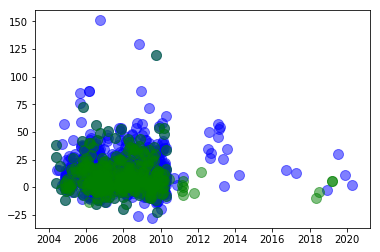

In [154]:
#Here is a graph of sentiment scores for Middle East (green) and US (blue) commentary articles over time
dates = [pd.to_datetime(d) for d in meCommentary['PubDate']]
dates2 = [pd.to_datetime(d) for d in usCommentary['PubDate']]
plt.scatter(dates2, usCommentary['ClusteredSentimentScores'], s =100, c = 'blue', alpha = 0.5)
plt.scatter(dates, meCommentary['ClusteredSentimentScores'], s =100, c = 'green', alpha = 0.5)

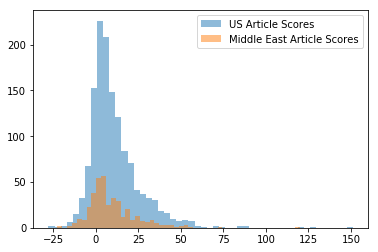

In [155]:
#Here is a graph of US vs ME article sentiment scores
pyplot.hist(usCommentary['ClusteredSentimentScores'], 50, alpha=0.5, label='US Article Scores')
pyplot.hist(meCommentary['ClusteredSentimentScores'], 50, alpha=0.5, label='Middle East Article Scores')
pyplot.legend(loc='upper right')
pyplot.show()

The following code is incomplete – as a next step I think I will try using flair embeddings instead of word2vec

In [1]:
################################UNSUPERVISED LEARNING USING FLAIR EMBEDDINGS##############################
from flair.embeddings import WordEmbeddings, FlairEmbeddings, StackedEmbeddings
from flair.data import Sentence, Token
# init embedding

In [2]:
# create a StackedEmbedding object that combines glove and forward/backward flair embeddings
stacked_embeddings = StackedEmbeddings([
                                        WordEmbeddings('news'),
                                        FlairEmbeddings('news-forward'),
                                        FlairEmbeddings('news-backward'),
                                       ])


In [12]:
allText = " ".join(allCommentary['Processed'])

In [13]:

sentence = Sentence(allText)

In [17]:
#Keeps crashing my laptop 
len(sentence)

3680686

In [ ]:
stacked_embeddings.embed(sentence)

In [ ]:
# just embed a sentence using the StackedEmbedding as you would with any single embedding.
stacked_embeddings.embed(sentence)

# now check out the embedded tokens.
for token in sentence:
    print(token)
    print(len(token.embedding))
    print(token.embedding)